
## Project Description

In this project we will be analyzing CO and NOX gas emissions from a power plant. The variables, their meanings and some statistics are given in the table below.

![PowerPlantEmissionsFeaturesTable](PowerPlantEmissionsFeaturesTable.PNG)

## Import Libraries

**Import the usual libraries for pandas and plotting, and sklearn.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

In [2]:
import sklearn
sklearn.__version__

'1.1.3'

In [3]:
pd.set_option('display.max_columns', 100)
RANDOM_STATE = 0

#### Get the Data


In [4]:
df = pd.read_csv('gas_emissions.csv')

In [5]:
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


#### Is there any missing data?

In [6]:
df.isna().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

#### What is the average value of AP for those points who have CO levels above 3 $mg/m^3$?

In [7]:
AP_W_co_more_than_3= df.AP[df.CO>3]
AP_W_co_more_than_3.mean()

1015.690017349063

#### Create a correlation map between the variables. Which variables have high correlation (> |0.9|)?

- TIY and AFDP
- CDP and AFDP
- TEY and GTEP
- CDP and GTEP
- TEY and TIT
- CDP and TIT
- CDP and TEY

<ipython-input-8-8da449ea5c67>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


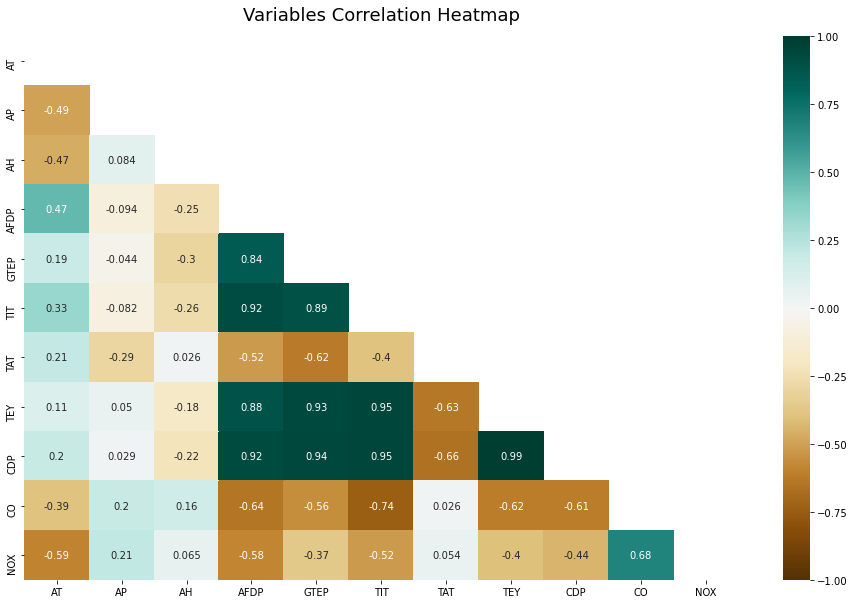

In [8]:
plt.figure(figsize=(16, 10))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Variables Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

#### Create a scatter plot of 'TEY' vs 'CDP'

Text(0.5, 1.0, 'TEY vs CDP')

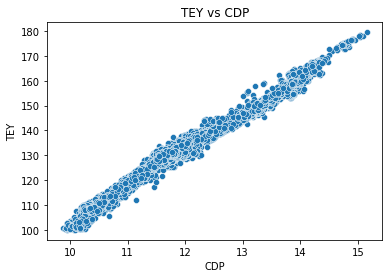

In [9]:
#fig,axes=plt.subplots(figsize=(10,10))
a_x=sns.scatterplot(data=df,x='CDP', y='TEY')
a_x.set_xlabel("CDP",fontsize= 10)
a_x.set_ylabel("TEY",fontsize= 10)
a_x.set_title('TEY vs CDP', fontdict={'fontsize':12}, pad=6)

#### Create histograms for CO and NOX.

<AxesSubplot:xlabel='CO', ylabel='Count'>

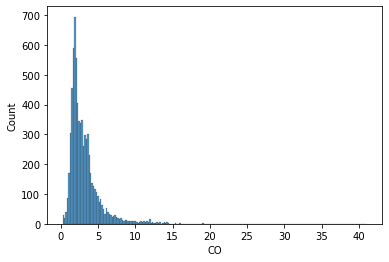

In [10]:
sns.histplot(data=df,x='CO')

<AxesSubplot:xlabel='NOX', ylabel='Count'>

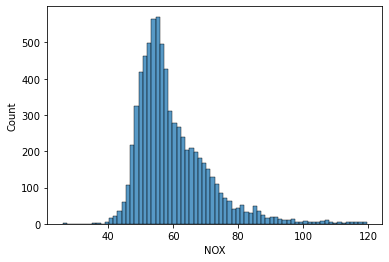

In [11]:
sns.histplot(data=df,x='NOX')

#### Create a sctter plot of CO vs NOX.

Text(0.5, 1.0, 'CO vs NOX')

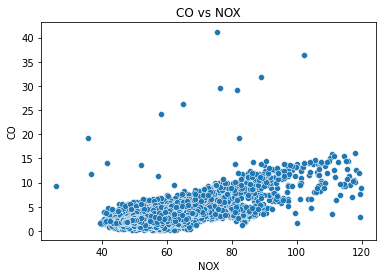

In [12]:
#fig,axes=plt.subplots(figsize=(10,10))
a_x=sns.scatterplot(data=df,x='NOX', y='CO')
a_x.set_xlabel("NOX",fontsize= 10)
a_x.set_ylabel("CO",fontsize= 10)
a_x.set_title('CO vs NOX', fontdict={'fontsize':12}, pad=6)

### Prepare data for machine learning

- We will predict CO using all the other variables.
- NOX, which is another emission gas, will not be used as predictor.
- CO is a continuous variable, thus we will be doing regression.
- Many of algorithms that do classification also have regression counterparts.

In [13]:
y = df.CO
X = df.drop(['CO', 'NOX'], axis=1)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=RANDOM_STATE)

In [15]:
# Standardization of the data
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [16]:
X_train.shape

(5316, 9)

In [17]:
X_val.shape

(1329, 9)

In [18]:
X_test.shape

(739, 9)

## Utility Functions

In [23]:
def error_rmse(true, pred):
    '''
    Returns the RMSE based on given true and predicted arrays.
    Both inputs are assumed to be numoy arrays
    '''
    from sklearn import metrics
    return np.sqrt(metrics.mean_squared_error(true, pred))

In [24]:
def print_regression_results(y_train, pred_train, y_val, pred_val):
    print('Train R2: {}'.format(metrics.r2_score(y_train, pred_train)))
    print('Validation R2: {}'.format(metrics.r2_score(y_val, pred_val)))
    print('Train error: {}'.format(error_rmse(y_train, pred_train)))
    print('Validation error: {}'.format(error_rmse(y_val, pred_val)))

In [25]:
# Let's create a function that can take train and validation data, perform regression, and store the results.
def apply_regressor(estimator, X_train, X_val, y_train, y_val, df_results, append_results = False, name = ''):
    
    estimator.fit(X_train, y_train)
    
    pred_train = estimator.predict(X_train)
    pred_val = estimator.predict(X_val)
    
    r2_tr = metrics.r2_score(y_train, pred_train).round(3)
    r2_val = metrics.r2_score(y_val, pred_val).round(3)
    
    rmse_tr = error_rmse(y_train, pred_train).round(3)
    rmse_val = error_rmse(y_val, pred_val).round(3)
    
    print_regression_results(y_train, pred_train, y_val, pred_val)
    
    df_results_new = pd.DataFrame(data=[[r2_tr, r2_val, rmse_tr, rmse_val]], 
                                  columns=['r2_tr', 'r2_val', 'rmse_tr', 'rmse_val'], index=[name])
    
    if append_results:
        if df_results is None:
            df_results = df_results_new
        else:
            df_results = pd.concat([df_results, df_results_new], axis=0)
    else: # Create the results of the new model
        df_results = df_results_new
    
    return df_results

## Linear Regresion

- Apply Linear Regression. Predict CO emission using other variables.
    - What is the model $R^2$ on training data?
    - What is the $R^2$ on validation data?
    - What is the Root Mean Squared Error (RMSE) on training data?
    - What is the RMSE on validation data?
    
> - $R^2$ higher is better. ($R^2$ is % variation in data being explained)  
> - RMSE lower is better. (RMSE (Root Mean Squared Error) is error, meaning the difference between predictions and actual data)  

Hint:  
- You can use the `r2_score` and `mean_squared_error` methods in `sklearn.metrics`.   
- You need to take the square root of Mean Squared Error to get to RMSE. (MSE $\rightarrow$ square root $\rightarrow$ RMSE)

In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
estimator = LinearRegression()
estimator.fit(X_train, y_train)

pred_train = estimator.predict(X_train)
pred_val = estimator.predict(X_val)

print_regression_results(y_train, pred_train, y_val, pred_val)

Train R2: 0.6640090820784397
Validation R2: 0.646343190818214
Train error: 1.2720122104103535
Validation error: 1.3884894690085985


In [28]:
df_results = None
df_results = apply_regressor(estimator, X_train, X_val, y_train, y_val, 
                             df_results, append_results=False, name="Linear Regression")
df_results

Train R2: 0.6640090820784397
Validation R2: 0.646343190818214
Train error: 1.2720122104103535
Validation error: 1.3884894690085985


,r2_tr,r2_val,rmse_tr,rmse_val
Linear Regression,0.664,0.646,1.272,1.388


## Random Forest Regression with 100 trees

- Apply Random Forest Regression with 100 trees. Predict CO emission using other variables.
    - What is the model $R^2$?
    - What is the $R^2$ on validation data?
    - What is the RMSE on training data?
    - What is the RMSE on validation data?

- Is training and validation score close? If not what might be the problem?
- If there is a large gap, try to decrease the gap by changing some hyperparameters of the Random Forest model. (In this analysis, any difference more than 0.10 $R^2$ difference can be assumed to be large.)
    - Once you reach a difference of less than or close to 0.10 between training $R^2$ and validation $R^2$ you can stop. 
    - During this process your training score will probably decrease, and that is OK. 

- The $R^2$ score between the training and validation set have a difference of about 0.21. This gap is somewhat large.

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
estimator = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)

In [31]:
df_results = apply_regressor(estimator, X_train, X_val, y_train, y_val, 
                             df_results, append_results=True, name="RF-100")
df_results

Train R2: 0.9635412068046666
Validation R2: 0.7558012206331827
Train error: 0.419014117669241
Validation error: 1.1537808394478866


,r2_tr,r2_val,rmse_tr,rmse_val
Linear Regression,0.664,0.646,1.272,1.388
RF-100,0.964,0.756,0.419,1.154


> The large gap between train and validation performance indicates overfitting.

I will increase the minimum number of points needed to perform split. This should help lowering the overfitting problem.

In [32]:
estimator = RandomForestRegressor(n_estimators=100, min_samples_split=100, random_state=RANDOM_STATE)

In [33]:
df_results = apply_regressor(estimator, X_train, X_val, y_train, y_val, 
                             df_results=df_results, append_results=True, name=str(estimator))
df_results

Train R2: 0.7980240972985977
Validation R2: 0.7457809641159987
Train error: 0.9862279128193115
Validation error: 1.1772145243505938


,r2_tr,r2_val,rmse_tr,rmse_val
Linear Regression,0.664,0.646,1.272,1.388
RF-100,0.964,0.756,0.419,1.154
"RandomForestRegressor(min_samples_split=100, random_state=0)",0.798,0.746,0.986,1.177


> Both the R2 score and the RMSE values between train and validation sets are close now, which is a good sign.

Even though both the train and validation scores are lower, the current performance is more indicative of out of sample performance.

## Support Vector Regression

- Apply Support Vector Regression. Predict CO emission using other variables.
    - What is the model $R^2$?
    - What is the $R^2$ on validation data?
    - What is the RMSE on training data?
    - What is the RMSE on validation data?
    
- The default parameters:  
    1. **Linear kernel SVR**  
    2. **Polynomial kernel SVR**  
    3. **RBF kernel SVR** 

In [35]:
from sklearn.svm import SVR

### Linear SVM Regressor

In [36]:
estimator = SVR(kernel='linear')
estimator

SVR(kernel='linear')

In [37]:
estimator.fit(X_train, y_train)

SVR(kernel='linear')

In [38]:
pred_train = estimator.predict(X_train)
pred_val = estimator.predict(X_val)

In [39]:
print_regression_results(y_train, pred_train, y_val, pred_val)

Train R2: 0.6244164650454904
Validation R2: 0.6021524213732284
Train error: 1.3448714796326715
Validation error: 1.4726852520481604


In [40]:
df_results = apply_regressor(estimator, X_train, X_val, y_train, y_val,
               df_results, append_results = True, name = "SVR linear")
df_results

Train R2: 0.6244164650454904
Validation R2: 0.6021524213732284
Train error: 1.3448714796326715
Validation error: 1.4726852520481604


,r2_tr,r2_val,rmse_tr,rmse_val
Linear Regression,0.664,0.646,1.272,1.388
RF-100,0.964,0.756,0.419,1.154
"RandomForestRegressor(min_samples_split=100, random_state=0)",0.798,0.746,0.986,1.177
SVR linear,0.624,0.602,1.345,1.473


### Polynomial Kernel SVM Regressor

In [41]:
from sklearn.svm import SVR
poly_svr_estimator = SVR(kernel='poly')

In [42]:
df_results = apply_regressor(estimator, X_train, X_val, y_train, y_val, 
                             df_results, append_results = True, name = "SVR poly")
df_results

Train R2: 0.6244164650454904
Validation R2: 0.6021524213732284
Train error: 1.3448714796326715
Validation error: 1.4726852520481604


,r2_tr,r2_val,rmse_tr,rmse_val
Linear Regression,0.664,0.646,1.272,1.388
RF-100,0.964,0.756,0.419,1.154
"RandomForestRegressor(min_samples_split=100, random_state=0)",0.798,0.746,0.986,1.177
SVR linear,0.624,0.602,1.345,1.473
SVR poly,0.624,0.602,1.345,1.473


### RBF Kernel SVM Regressor

In [43]:
from sklearn.svm import SVR
estimator = SVR(kernel='rbf')

In [44]:
df_results = apply_regressor(estimator, X_train, X_val, y_train, y_val,
                             df_results, append_results = True, name = "SVR RBF")
df_results

Train R2: 0.7653225070588421
Validation R2: 0.7476173201040636
Train error: 1.0630733502205558
Validation error: 1.172955002593975


,r2_tr,r2_val,rmse_tr,rmse_val
Linear Regression,0.664,0.646,1.272,1.388
RF-100,0.964,0.756,0.419,1.154
"RandomForestRegressor(min_samples_split=100, random_state=0)",0.798,0.746,0.986,1.177
SVR linear,0.624,0.602,1.345,1.473
SVR poly,0.624,0.602,1.345,1.473
SVR RBF,0.765,0.748,1.063,1.173


### Hyperparameter tuning to increase $R^2$ 

- RBF Kernel SVM and perform hyperparameter tuning. See if you can increase the $R^2$ score.   
    - Using:  
          'C': [1, 10, 100, 1000]
          'gamma': [0.001, 0.01, 0.1, 1]  

    - What is the model $R^2$?
    - What is the $R^2$ on validation data?
    - What is the RMSE on training data?
    - What is the RMSE on validation data?

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
reg = SVR(kernel='rbf')

In [47]:
param_grid = {'C': [1, 10, 100, 1000],
              'gamma': [0.001, 0.01, 0.1, 1]}

In [48]:
reg = SVR(kernel='rbf')
param_grid = {'C': [1, 10, 100, 1000],
              'gamma': [0.001, 0.01, 0.1, 1]}
gs = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='r2', cv=3, n_jobs=-1)
gs.fit(X_train, y_train)
estimator = gs.best_estimator_
df_results = apply_regressor(estimator, X_train, X_val, y_train, y_val, 
                             df_results, append_results = True, name = "SVR RBF"+ str(gs.best_params_))
df_results

Train R2: 0.7922405098710099
Validation R2: 0.756850053336899
Train error: 1.000248586950844
Validation error: 1.1513004313829323


,r2_tr,r2_val,rmse_tr,rmse_val
Linear Regression,0.664,0.646,1.272,1.388
RF-100,0.964,0.756,0.419,1.154
"RandomForestRegressor(min_samples_split=100, random_state=0)",0.798,0.746,0.986,1.177
SVR linear,0.624,0.602,1.345,1.473
SVR poly,0.624,0.602,1.345,1.473
SVR RBF,0.765,0.748,1.063,1.173
"SVR RBF{'C': 1000, 'gamma': 0.01}",0.792,0.757,1.000,1.151


In [49]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             scoring='r2')

In [50]:
gs.best_estimator_

SVR(C=1000, gamma=0.01)

## PCA Transform

- Apply PCA and transform the data. 
    - For PCA we need to decide on the number of  components. Take sufficient number of components based on variance explained 
        - generally it is chosen as the number of components that can explain 90% of the variance 
        - or cross-validation accuracy using an ML model.

- Use the PCA transformed data to perform regression on all previous models : 
    - Linear Regression
    - Random Forest Regression (Optional to do hyper parameter tuning)
    - RBF Kernel Support Vector Regression (Optional to do hyper parameter tuning)
  
- For each model:  
    - What is the model $R^2$?
    - What is the $R^2$ on validation data?
    - What is the RMSE on training data?
    - What is the RMSE on validation data?
    
- These models with their counterparts are then observeerd to see any change in performance. For example: Compare `PCA RBF SVR` with the `RBF SVR` model from before. 


- Comparing the $R^2$ differnce between the train and validation set for without PCA and with PCA.
    - Linear regression w/o PCA = 0.02. Linear regresion with PCA = 0.02.. Hence PCA dimensionality reducation has no significant effect.
    - RF w/o PCA = 0.2 . RF with PCA=0.22, the PCA dimensionality reduction has no significant improvement on the RF model.
    - rbf SVM w/o PCA = 0.01 with PCA=0.01  the PCA dimensionality reduction has no significant improvement on the model. 
    

In [52]:
from sklearn.decomposition import PCA

In [53]:
pca = PCA(n_components=None)

pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

[0.58158952 0.78924196 0.88751722 0.94337792 0.98704348 0.9959942
 0.99975821 0.99992456 1.        ]


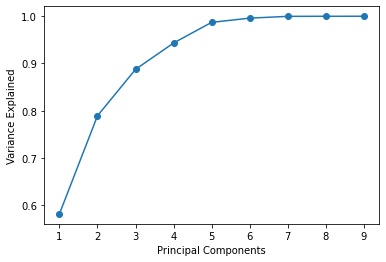

In [54]:
print(pca.explained_variance_ratio_.cumsum())
plt.plot(pca.explained_variance_ratio_.cumsum(), '-o');
plt.xticks(ticks= range(X_train_pca.shape[1]), labels=[i+1 for i in range(X_train_pca.shape[1])])
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.show()

> Choose the number of components, which is 5 from the above PCA graph

In [55]:
X_train_pca2 = X_train_pca[:, 0:5]
X_val_pca2 = X_val_pca[:, 0:5]
X_test_pca2 = X_test_pca[:, 0:5]

> Or apply cross-validation to find the best number of components:

In [56]:
df_results_pca = None
estimator = SVR(C=10, gamma=0.1, kernel='rbf')
for i in range(1, X_train_pca.shape[1]+1):
    print("\nNumber of PCA components: {}".format(i))
    X_train_pca2 = X_train_pca[:, 0:i]
    X_val_pca2 = X_val_pca[:, 0:i]
    
    df_results_pca = apply_regressor(estimator, X_train_pca2, X_val_pca2, y_train, y_val,
               df_results_pca, append_results = True, name = 'PCA' + str(i) + '_' + "SVR PCA" + str(gs.best_params_))


Number of PCA components: 1
Train R2: 0.5511321758152049
Validation R2: 0.5180455851262757
Train error: 1.4702349714611302
Validation error: 1.6208937942685486

Number of PCA components: 2
Train R2: 0.6697094830926285
Validation R2: 0.6535281856882771
Train error: 1.261175610496181
Validation error: 1.3743126157700662

Number of PCA components: 3
Train R2: 0.6867058288670491
Validation R2: 0.6781113159842672
Train error: 1.228297784647761
Validation error: 1.3246600316434403

Number of PCA components: 4
Train R2: 0.7678995597449753
Validation R2: 0.7459255624575631
Train error: 1.0572202992360078
Validation error: 1.1768796802668537

Number of PCA components: 5
Train R2: 0.788832644198742
Validation R2: 0.7521975437226679
Train error: 1.0084187265587075
Validation error: 1.1622629170822358

Number of PCA components: 6
Train R2: 0.7914527648443804
Validation R2: 0.7498852617528391
Train error: 1.0021430741023942
Validation error: 1.1676729509235972

Number of PCA components: 7
Train R2

In [57]:
df_results_pca

,r2_tr,r2_val,rmse_tr,rmse_val
"PCA1_SVR PCA{'C': 1000, 'gamma': 0.01}",0.551,0.518,1.470,1.621
"PCA2_SVR PCA{'C': 1000, 'gamma': 0.01}",0.670,0.654,1.261,1.374
"PCA3_SVR PCA{'C': 1000, 'gamma': 0.01}",0.687,0.678,1.228,1.325
"PCA4_SVR PCA{'C': 1000, 'gamma': 0.01}",0.768,0.746,1.057,1.177
"PCA5_SVR PCA{'C': 1000, 'gamma': 0.01}",0.789,0.752,1.008,1.162
"PCA6_SVR PCA{'C': 1000, 'gamma': 0.01}",0.791,0.750,1.002,1.168
"PCA7_SVR PCA{'C': 1000, 'gamma': 0.01}",0.796,0.754,0.992,1.159
"PCA8_SVR PCA{'C': 1000, 'gamma': 0.01}",0.796,0.754,0.990,1.158
"PCA9_SVR PCA{'C': 1000, 'gamma': 0.01}",0.796,0.754,0.990,1.158


> I will go with 5 components for PCA.

In [58]:
X_train_pca2 = X_train_pca[:, 0:5]
X_val_pca2 = X_val_pca[:, 0:5]
X_test_pca2 = X_test_pca[:, 0:5]

In [59]:
X_train_pca2

array([[-0.62298262,  0.40361984,  2.06191285, -0.62672397, -0.88959931],
       [ 2.66271643, -1.20910093,  0.50391815, -0.22692972,  0.49677271],
       [-0.22666053, -0.97242419, -1.42863023, -0.16538402,  0.32216955],
       ...,
       [-0.22284723,  0.54472394,  0.46163485, -0.5310521 , -0.9961965 ],
       [-1.74491442,  0.89615756, -1.05051494,  0.35344573, -1.31768775],
       [ 2.46984843, -1.38561685,  0.58176005, -0.35946016,  0.4226196 ]])

In [60]:
X_train_pca2.shape

(5316, 5)

**Linear Regression with PCA transformed data**

In [61]:
estimator = LinearRegression()
df_results = apply_regressor(estimator, X_train, X_val, y_train, y_val, 
                             df_results, append_results = True, name = "PCA LinReg")

Train R2: 0.6640090820784397
Validation R2: 0.646343190818214
Train error: 1.2720122104103535
Validation error: 1.3884894690085985


**RF Regressor with PCA transformed data with hyperparameter tuning**

In [63]:
reg = RandomForestRegressor()
param_grid = {'min_samples_split': [20, 100, 200],
              'min_samples_leaf': [10, 50, 100]}
gs = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='r2', cv=3, n_jobs=-1)
gs.fit(X_train, y_train)
estimator = gs.best_estimator_
df_results = apply_regressor(estimator, X_train, X_val, y_train, y_val, 
                             df_results, append_results = True, name = "PCA RF"+ str(gs.best_params_))
df_results

Train R2: 0.8228381950218016
Validation R2: 0.7539062046828123
Train error: 0.923660899256578
Validation error: 1.1582489365520898


,r2_tr,r2_val,rmse_tr,rmse_val
Linear Regression,0.664,0.646,1.272,1.388
RF-100,0.964,0.756,0.419,1.154
"RandomForestRegressor(min_samples_split=100, random_state=0)",0.798,0.746,0.986,1.177
SVR linear,0.624,0.602,1.345,1.473
SVR poly,0.624,0.602,1.345,1.473
SVR RBF,0.765,0.748,1.063,1.173
"SVR RBF{'C': 1000, 'gamma': 0.01}",0.792,0.757,1.000,1.151
"SVR RBF{'C': 1000, 'gamma': 0.01}",0.792,0.757,1.000,1.151
PCA LinReg,0.664,0.646,1.272,1.388
"PCA RF{'min_samples_leaf': 10, 'min_samples_split': 20}",0.823,0.754,0.924,1.158


**SVM Regression with PCA transformed data**

In [64]:
reg = SVR(kernel='rbf')
param_grid = {'C': [1, 10, 100, 1000],
              'gamma': [0.001, 0.01, 0.1, 1]}
gs = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='r2', cv=3, n_jobs=-1)
gs.fit(X_train, y_train)
estimator = gs.best_estimator_
df_results = apply_regressor(estimator, X_train, X_val, y_train, y_val, 
                             df_results, append_results = True, name = "PCA RBF SVM"+ str(gs.best_params_))
df_results

Train R2: 0.7922405098710099
Validation R2: 0.756850053336899
Train error: 1.000248586950844
Validation error: 1.1513004313829323


,r2_tr,r2_val,rmse_tr,rmse_val
Linear Regression,0.664,0.646,1.272,1.388
RF-100,0.964,0.756,0.419,1.154
"RandomForestRegressor(min_samples_split=100, random_state=0)",0.798,0.746,0.986,1.177
SVR linear,0.624,0.602,1.345,1.473
SVR poly,0.624,0.602,1.345,1.473
SVR RBF,0.765,0.748,1.063,1.173
"SVR RBF{'C': 1000, 'gamma': 0.01}",0.792,0.757,1.000,1.151
"SVR RBF{'C': 1000, 'gamma': 0.01}",0.792,0.757,1.000,1.151
PCA LinReg,0.664,0.646,1.272,1.388
"PCA RF{'min_samples_leaf': 10, 'min_samples_split': 20}",0.823,0.754,0.924,1.158


- I see no change in SVR (with and without PCA performance is same.)
- Lin Reg on PCA transformed data has slightly gotten worse.
- RF on PCA transformed data is performing better.

## Q7 [10]

#### Let's do  classification 

We will convert CO target values into binary form by comparing them to a threshold. $ 0 - 3  mg/m^3$ is the range of max 8-hour avg. ambient CO in most US cities. So let's take that.  
[CO Levels of Concern in Government Recommendations and Regulations](https://www.carbonmonoxidekills.com/are-you-at-risk/carbon-monoxide-levels/)

In [65]:
from sklearn.preprocessing import Binarizer

In [66]:
binarizer = Binarizer(threshold=3)

In [67]:
y_train_cat = binarizer.transform(y_train.values.reshape(-1,1)).ravel()
y_val_cat = binarizer.transform(y_val.values.reshape(-1,1)).ravel()
y_test_cat = binarizer.transform(y_test.values.reshape(-1,1)).ravel()

In [68]:
y_train_cat = pd.Series(y_train_cat)

<AxesSubplot:>

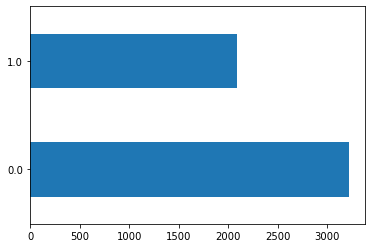

In [69]:
y_train_cat.value_counts().plot.barh()

### Fit RBF Kernel SVM Classifier

#### 1. Standardized training data 
- Using the standardized training data perform grid search:
    - Find the best combination of the `C` and `gamma` hyper-parameters.  
- For the best model:
    - Either using the confusion matrix or the methods in `sklearn.metrics` get the following metrics on the validation set:
     - Create confusion matrix
     - Recall (Sensitivity)
     - Specificity
     - Precision
     - Balanced Accuracy
     - F1 Score
     

#### 2. PCA transformed training data 
- Using the **pca** transformed training data `X_train_pca2` perform grid search:
    - Find the best combination of the `C` and `gamma` hyper-parameters.  
- For the best model:
    - Either using the confusion matrix or the methods in `sklearn.metrics` get the following metrics on the validation set `X_val_pca2`:
         - Create confusion matrix
         - Recall (Sensitivity)
         - Specificity
         - Precision
         - Balanced Accuracy
         - F1 Score


In [70]:
from sklearn.svm import SVC

In [71]:
estimator = SVC(kernel ='rbf')

### SVC Model 1

In [72]:
param_grid = {'C': [1, 10, 100, 1000],
              'gamma': [0.001, 0.01, 0.1, 1]}
estimator = SVC(kernel='rbf')
gs = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='accuracy', cv=3)
# Fit on standardized data
gs.fit(X_train, y_train_cat)
estimator = gs.best_estimator_
estimator

SVC(C=100, gamma=0.1)

Accuracy Train:
0.9351015801354402
Accuracy Validation: 
0.9194883370955605
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       812
         1.0       0.90      0.89      0.90       517

    accuracy                           0.92      1329
   macro avg       0.92      0.91      0.92      1329
weighted avg       0.92      0.92      0.92      1329



C:\Users\soboa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


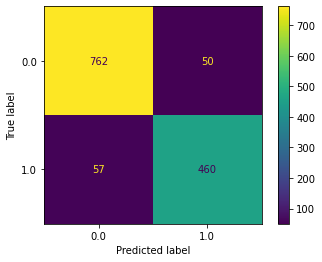

In [73]:
pred_train = estimator.predict(X_train)
pred_val = estimator.predict(X_val)

print('Accuracy Train:')
print(metrics.accuracy_score(y_train_cat, pred_train))
print('Accuracy Validation: ')
print(metrics.accuracy_score(y_val_cat, pred_val))

print(metrics.plot_confusion_matrix(estimator, X_val, y_val_cat))
print(metrics.classification_report(y_val_cat, pred_val))


### SVC Model 2

In [80]:
param_grid = {'C': [1, 10, 100, 1000],
              'gamma': [0.001, 0.01, 0.1, 1]}
estimator = SVC(kernel='rbf')
gs = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='accuracy', cv=3)
# Fit on PCA data
gs.fit(X_train_pca2, y_train_cat)
estimator = gs.best_estimator_
estimator

SVC(C=1, gamma=1)

Accuracy Train:
0.9302106847253574
Accuracy Validation: 
0.9112114371708051


C:\Users\soboa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       812
         1.0       0.90      0.86      0.88       517

    accuracy                           0.91      1329
   macro avg       0.91      0.90      0.91      1329
weighted avg       0.91      0.91      0.91      1329



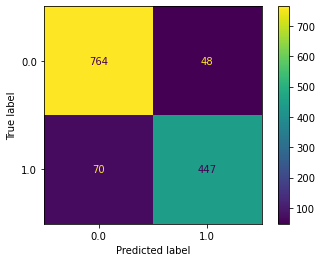

In [82]:
pred_train = estimator.predict(X_train_pca2)
pred_val = estimator.predict(X_val_pca2)

print('Accuracy Train:')
print(metrics.accuracy_score(y_train_cat, pred_train))
print('Accuracy Validation: ')
print(metrics.accuracy_score(y_val_cat, pred_val))

print(metrics.plot_confusion_matrix(estimator, X_val_pca2, y_val_cat))
print(metrics.classification_report(y_val_cat, pred_val))



### Selecting best Regression model on **test set**

> from the Regression model the following three models perform well , thus we inspect their performance on the **test set** 
- SVR RBF{'C': 1000, 'gamma': 0.01}
- PCA RF{'min_samples_leaf': 10, 'min_samples_split': 20}	
- RandomForestRegressor(min_samples_split=100, random_state=0)	

In [135]:
def print_regression_test_results(y_test, pred_test):
    print('Test R2: {}'.format(metrics.r2_score(y_test, pred_test)))
    print('Test error: {}'.format(error_rmse(y_test, pred_test)))


In [136]:
def test_specific_model(estimator, X_test, y_test, df_results, append_results=False, name=''):
    estimator.fit(X_test, y_test)
    pred_test = estimator.predict(X_test)

    r2_test = metrics.r2_score(y_test, pred_test).round(3)
    rmse_test = error_rmse(y_test, pred_test).round(3)

    print_regression_test_results(y_test, pred_test)

    df_results_new = pd.DataFrame(data=[[r2_test, rmse_test]],
                                  columns=['r2_test', 'rmse_test'], index=[name])

    if append_results:
        if df_results is None:
            df_results = df_results_new
        else:
            df_results = pd.concat([df_results, df_results_new], axis=0)
    else:  # Create the results of the new model
        df_results = df_results_new

    return df_results

#### SVR RBF on test set

In [137]:
# SVR RBF model with parameters
svr_rbf_model = SVR(kernel='rbf', C=1000, gamma=0.01)

# Results DataFrame (initialize or use an existing one)
results_df_ = None

# Test the SVR RBF model on the test set
results_df_ = test_specific_model(svr_rbf_model, X_test, y_test, results_df_, append_results=False, name='SVR_RBF_C1000_gamma0.01')

# Print or use the results_df as needed
results_df_


Test R2: 0.6091057494623618
Test error: 1.4591345688552373


,r2_test,rmse_test
SVR_RBF_C1000_gamma0.01,0.609,1.459


####  Random forest Regressor on test set

In [138]:
# SVR RBF model with parameters
rf_model = RandomForestRegressor(min_samples_split=100, random_state=0)


# Test the SVR RBF model on the test set
results_df_ = test_specific_model(rf_model, X_test, y_test, results_df_, append_results=True, name='RF_min_samples_split100_random_state0')

# Print or use the results_df as needed
results_df_


Test R2: 0.5226503201296644
Test error: 1.612441707426714


,r2_test,rmse_test
SVR_RBF_C1000_gamma0.01,0.609,1.459
RF_min_samples_split100_random_state0,0.523,1.612


#### PCA and Random forest Regressor on test set

In [139]:
# Random Forest model with parameters
pca_rf_model = RandomForestRegressor(min_samples_leaf=10, min_samples_split=20)

# Test the PCA Random Forest model on the test set
results_df_ = test_specific_model(pca_rf_model, X_test_pca2, y_test, results_df_, append_results=True, name='PCA_RF_min_samples_leaf10_min_samples_split20')

# Print or use the results_df as needed
results_df_

Test R2: 0.605036757128405
Test error: 1.4667092984724472


,r2_test,rmse_test
SVR_RBF_C1000_gamma0.01,0.609,1.459
RF_min_samples_split100_random_state0,0.523,1.612
PCA_RF_min_samples_leaf10_min_samples_split20,0.605,1.467
